<h1><center>Распознавание жестов</center></h1>

<h1><center>Практическая часть</center></h1>

Загрузим все необходимые библиотеки и начнем:

In [9]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

## Часть 1. Подготовка данных

Шаг 1.

Создадим объекты для необходимых трансформаций нашего датасета:

In [10]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

Шаг 2.

Загрузим dataset и распакуем содержимое в папку 'leapGestRecog'.

Видим, что внутри две папки с тестовыми и тренировочными картинками:

In [11]:
data_dir = './hand'
print(os.listdir(data_dir))

['test', 'train']


Если посмотрим что в них, то у видим 10 папок. Каждая под один из 10 классов жестов:

In [12]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
test Classes - ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']


Сразу давайте напишем словарь для сопоставления выхода с нейронной сети с названием определенного жеста:

In [13]:
digit_to_classname = {0:'01_palm', 1:'02_l', 2:'03_fist', 3:'04_fist_moved', 4:'05_thumb', 5:'06_index', 6:'07_ok', 7:'08_palm_moved', 8:'09_c', 9:'10_down'}

Используем ImageFolder для каждой выборки:

In [14]:
train_dataset = ImageFolder(data_dir + '/train', train_transforms)
test_dataset  = ImageFolder(data_dir + '/test', test_transforms)

In [15]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: ./hand/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               ToTensor()
           )

Определим размер батча:

In [16]:
batch_size = 50

Шаг 3.

Создадим наши даталоадеры:

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

Создадим функцию для просмотра случайных картинок из получившегося датасета:

In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 240, 640])


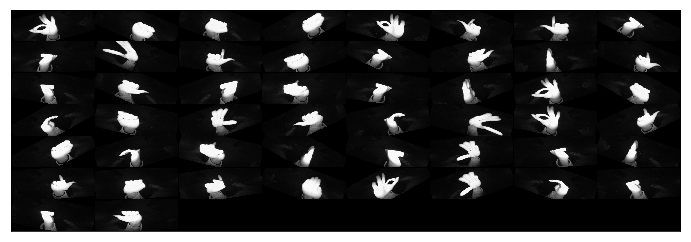

In [19]:
show_batch(train_dataloader)

Шаг 4.

Напишем функции для перевода наших моделей и Даталоадеров на необходимое оборудование:

In [20]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

Узнаем какое оборудование у нас:

In [21]:
device = get_default_device()
device

device(type='cpu')

Воспользуемся функциями написанными выше:

In [22]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

## Часть 2. Создание модели

Опишем нашу модель для распознавания эмоций:

In [23]:


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
#        self.conv5 = self.conv_block(256, 512)
#        self.conv6 = self.conv_block(512, 512, pool=True)
#        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
#        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(128, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
 #       out = self.conv3(out)
 #       out = self.conv4(out)
 #       out = self.res2(out) + out
 #       out = self.drop2(out)
        
 #       out = self.conv5(out)
 #       out = self.conv6(out)
 #       out = self.res3(out) + out
 #       out = self.drop3(out)
        
        out = self.classifier(out)
        return out

Давайте я дам некоторые пояснения по поводу использования того или иного слоя.

BatchNorm2d - вывод со сверточного слоя может быть довольно большим, что может негативно повлиять на нашу модель. А этот слой просто нормализует полученные данные.

ELU - можно использовать и Relu, но ELU быстрее стремится к нулю.

In [24]:
model = to_device(ResNet(1, len(classes_train)), device)

In [25]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Часть 3. Обучение

In [26]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 2#50
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [27]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

2 epochs, 40 total_steps per epoch


Добавим learning_rate_sheduler:

In [28]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

1.6.0+cpu


In [ ]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = Variable(data), Variable(labels)
#        data = data.cuda()
#        labels = labels.cuda()
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)
    

In [ ]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [ ]:
torch.save(model.state_dict(), 'hand.pth')

In [ ]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('hand.pth'))
net.eval()

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_dl):
        images, labels = data
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = net(images)
        plt.title(f'gaused - {digit_to_classname(outputs[0].argmax())}, groud truth - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break